## 🔗 Open This Notebook in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DavidLangworthy/ds4s/blob/master/days/day02/starter/day02_starter.ipynb)

# ⚡ Day 2 – Fossil Fuels vs. Renewables
### Comparing energy transitions with grouped bar charts

We now move from climate outcomes to energy systems. Today's notebook helps you quantify how five major economies are shifting their energy mix — and how different renewable technologies contribute. We'll work in short cycles again: load → check → transform → visualize → reflect.

### Data card — Our World in Data energy share series
- **Source:** [Our World in Data – Energy Mix](https://ourworldindata.org/energy-mix)
- **Temporal coverage:** 1965–2023 (annual)
- **Geographic coverage:** Global plus individual countries/regions
- **Units:** Share of primary energy consumption (% of total)
- **Files used today:** Total renewable share, hydro share, solar share, wind share
- **Processing notes:** Shares are calculated from BP Statistical Review. Negative or missing values can appear for smaller countries.
- **Caveats:** Country definitions follow BP conventions (e.g., EU aggregated). Shares may not sum to 100% because non-renewable categories are not included in this subset.

### Preview: today's target chart
A grouped bar chart comparing renewable technology shares in 2023, with a caption that spells out the headline claim.

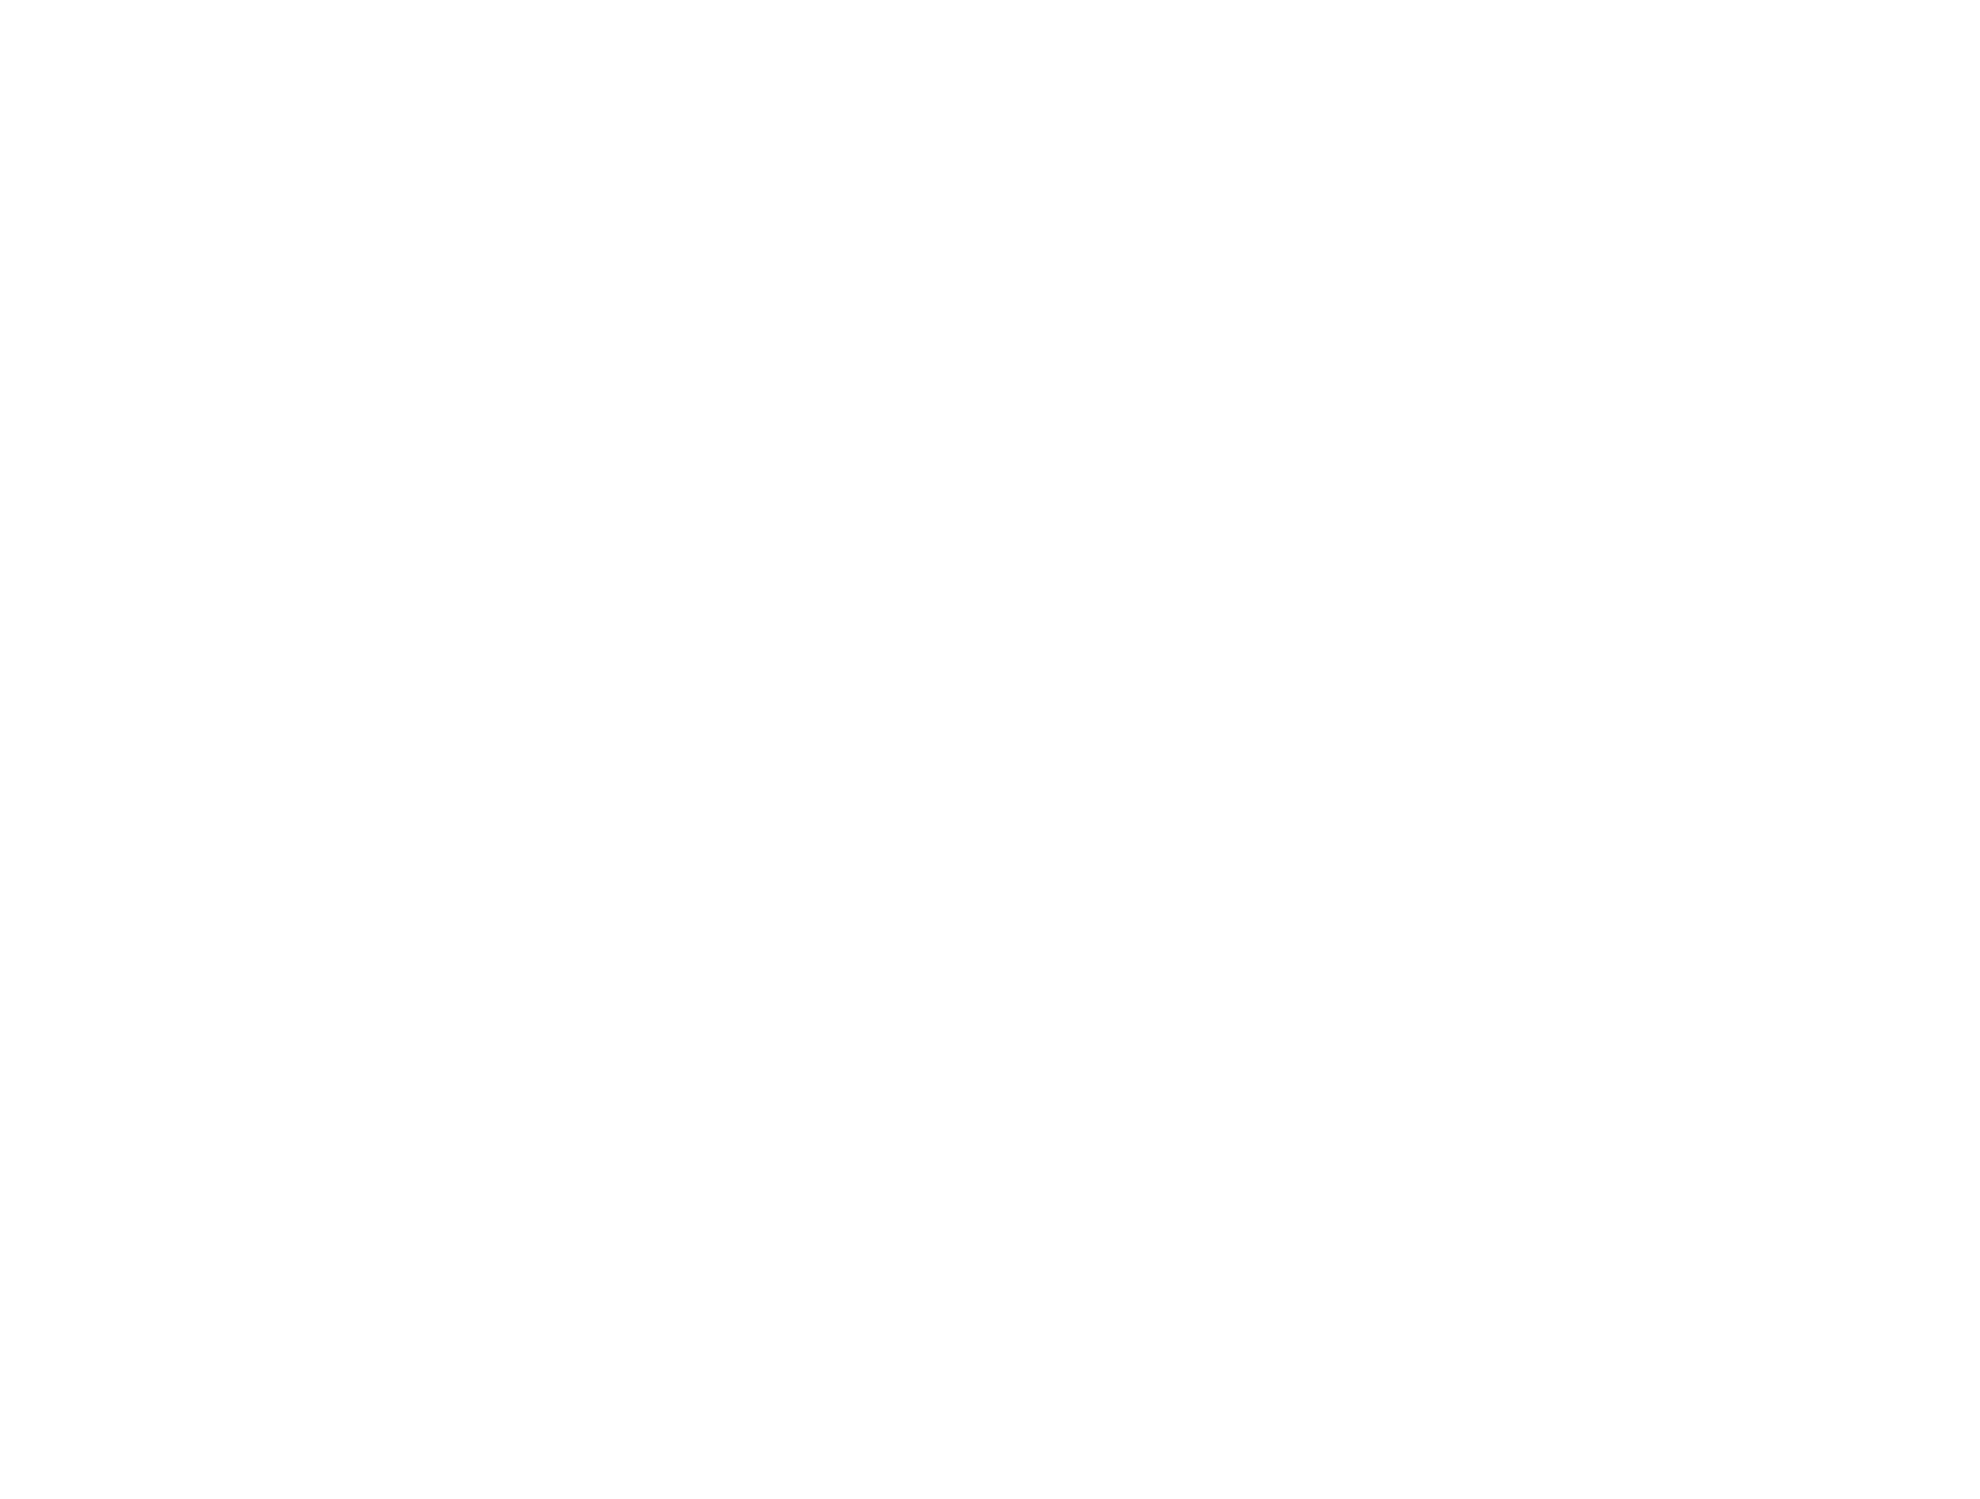

In [1]:
from pathlib import Path
from warnings import warn

import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import Image, display

CANDIDATES = [Path.cwd(), *Path.cwd().parents]
for candidate in CANDIDATES:
    if (candidate / "data").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise FileNotFoundError("Couldn't find the project root containing a data/ folder.")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_BASE = "https://raw.githubusercontent.com/DavidLangworthy/ds4s/master/data"
PLOTS_DIR = PROJECT_ROOT / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

COLORBLIND_FRIENDLY = ["#2E86AB", "#F18F01", "#A23B72", "#C73E1D", "#2EC4B6", "#33673B"]

if (PLOTS_DIR / "day02_solution_plot.png").exists():
    display(Image(filename=PLOTS_DIR / "day02_solution_plot.png", width=420))
else:
    print("Preview image not found; continue with the workflow.")


def load_data(csv_name: str, **read_kwargs) -> pd.DataFrame:
    path = DATA_DIR / csv_name
    if not path.exists():
        url = f"{RAW_DATA_BASE}/{csv_name}"
        print(f"Local file not found. Downloading {csv_name} from GitHub…")
        response = requests.get(url, timeout=30)
        try:
            response.raise_for_status()
        except requests.HTTPError as exc:
            raise FileNotFoundError(
                f"Could not retrieve {csv_name} from {url} (status {response.status_code})."
            ) from exc
        path.parent.mkdir(parents=True, exist_ok=True)
        path.write_bytes(response.content)
    df = pd.read_csv(path, **read_kwargs)
    print(f"Loaded {csv_name} → {df.shape[0]:,} rows × {df.shape[1]} columns.")
    return df

def validate_columns(df: pd.DataFrame, required: list[str]) -> None:
    missing = [col for col in required if col not in df.columns]
    if missing:
        warn(f"Missing columns: {missing}")
    else:
        print("✅ Columns look good:", required)


def expect_rows_between(df: pd.DataFrame, lower: int, upper: int) -> None:
    rows = len(df)
    if rows < lower or rows > upper:
        warn(f"Row count {rows:,} outside the expected range ({lower:,}–{upper:,}).")
    else:
        print(f"✅ Row count within expected range ({rows:,}).")


def quick_diagnostics(df: pd.DataFrame, name: str = "DataFrame") -> None:
    print(f"--- Quick check for {name} ---")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("Missing values:", df.isna().sum())
    display(df.head())


def check_story_fields(**fields) -> None:
    empty = [key for key, value in fields.items() if not str(value).strip()]
    if empty:
        warn(f"These storytelling fields still need text: {', '.join(empty)}")
    else:
        print("✅ Story scaffolding complete. Ready to plot!")


def baseline_style():
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["axes.facecolor"] = "#F8FAFC"


def save_last_fig(filename: str) -> None:
    path = PLOTS_DIR / filename
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Figure saved to {path.relative_to(PROJECT_ROOT)}")


## Step 1. Load renewable share data
We'll start with the total renewable share dataset and sanity-check the structure.

### Mini example: quick diagnostics on a tiny table
Before loading the full dataset, see how the helper surfaces shape and column info.

In [ ]:
import pandas as pd
demo_energy = pd.DataFrame({
    "Entity": ["Exampleland"],
    "Year": [2023],
    "Renewables (% equivalent primary energy)": [12.5],
})
quick_diagnostics(demo_energy, name="demo energy share")


In [2]:
renewables_total = load_data("01 renewable-share-energy.csv")
quick_diagnostics(renewables_total, name="renewable share raw")


Loaded 01 renewable-share-energy.csv → 5,603 rows × 4 columns.
--- Quick check for renewable share raw ---
Shape: (5603, 4)
Columns: ['Entity', 'Code', 'Year', 'Renewables (% equivalent primary energy)']
Missing values: Entity                                         0
Code                                        1311
Year                                           0
Renewables (% equivalent primary energy)       0
dtype: int64


,Entity,Code,Year,Renewables (% equivalent primary energy)
0,Africa,NaN,1965,5.747495
1,Africa,NaN,1966,6.122062
2,Africa,NaN,1967,6.325731
3,Africa,NaN,1968,7.005293
4,Africa,NaN,1969,7.956088


✅ **Checkpoint:** Expect columns `Entity`, `Code`, `Year`, and `Renewables (% equivalent primary energy)` covering ~300 entities.

## Step 2. Load component technology shares
Hydro, solar, and wind are provided as separate files. We'll bring them together so we can compare technologies side by side.

### Mini example: aligning technology tables
Here's how dropping the `Code` column and merging on `Entity`/`Year` keeps values side by side.

In [ ]:
import pandas as pd
left = pd.DataFrame({"Entity": ["Exampleland"], "Year": [2023], "renewables_pct": [30]})
right = pd.DataFrame({"Entity": ["Exampleland"], "Year": [2023], "hydro_pct": [18]})
merged = left.merge(right, on=["Entity", "Year"], how="left")
print(merged)


In [3]:
hydro = load_data("06 hydro-share-energy.csv")
solar = load_data("14 solar-share-energy.csv")
wind = load_data("10 wind-share-energy.csv")

for name, frame in {"hydro": hydro, "solar": solar, "wind": wind}.items():
    validate_columns(frame, ["Entity", "Year"])
    expect_rows_between(frame, 2000, 10000)


Loaded 06 hydro-share-energy.csv → 5,603 rows × 4 columns.
Loaded 14 solar-share-energy.csv → 5,442 rows × 4 columns.
Loaded 10 wind-share-energy.csv → 5,445 rows × 4 columns.
✅ Columns look good: ['Entity', 'Year']
✅ Row count within expected range (5,603).
✅ Columns look good: ['Entity', 'Year']
✅ Row count within expected range (5,442).
✅ Columns look good: ['Entity', 'Year']
✅ Row count within expected range (5,445).


In [4]:
renewables_tidy = renewables_total.drop(columns=["Code"], errors="ignore")

def rename_value_column(df: pd.DataFrame, current: str, new: str) -> pd.DataFrame:
    subset = df.drop(columns=["Code"], errors="ignore").copy()
    return subset.rename(columns={current: new})

tech_shares = (
    rename_value_column(renewables_tidy, "Renewables (% equivalent primary energy)", "renewables_pct")
    .merge(
        rename_value_column(hydro, "Hydro (% equivalent primary energy)", "hydro_pct"),
        on=["Entity", "Year"],
        how="left"
    )
    .merge(
        rename_value_column(wind, "Wind (% equivalent primary energy)", "wind_pct"),
        on=["Entity", "Year"],
        how="left"
    )
    .merge(
        rename_value_column(solar, "Solar (% equivalent primary energy)", "solar_pct"),
        on=["Entity", "Year"],
        how="left"
    )
)

quick_diagnostics(tech_shares, name="merged technology shares")


--- Quick check for merged technology shares ---
Shape: (5603, 6)
Columns: ['Entity', 'Year', 'renewables_pct', 'hydro_pct', 'wind_pct', 'solar_pct']
Missing values: Entity              0
Year                0
renewables_pct      0
hydro_pct           0
wind_pct          165
solar_pct         168
dtype: int64


,Entity,Year,renewables_pct,hydro_pct,wind_pct,solar_pct
0,Africa,1965,5.747495,5.747495,0.0,NaN
1,Africa,1966,6.122062,6.122062,0.0,NaN
2,Africa,1967,6.325731,6.325731,0.0,NaN
3,Africa,1968,7.005293,7.005293,0.0,NaN
4,Africa,1969,7.956088,7.956088,0.0,NaN


### Mini self-diagnostic
If you see duplicate columns suffixed with `_x` or `_y`, double-check the `drop(columns=['Code'])` operations before the merges.

## Step 3. Focus on five key economies in 2023
We'll filter for the latest common year and compute an "other renewables" bucket to complete the stacked categories.

### Mini example: filling gaps and clipping totals
This tiny series shows how we replace missing shares with zero and keep totals from dipping below zero.

In [ ]:
import pandas as pd
mini_focus = pd.DataFrame({
    "renewables_pct": [35],
    "hydro_pct": [20],
    "wind_pct": [8],
    "solar_pct": [6],
})
mini_focus[["hydro_pct", "wind_pct", "solar_pct"]] = mini_focus[["hydro_pct", "wind_pct", "solar_pct"]].fillna(0)
mini_focus["other_pct"] = (mini_focus["renewables_pct"] - mini_focus[["hydro_pct", "wind_pct", "solar_pct"]].sum(axis=1)).clip(lower=0)
print(mini_focus)


In [5]:
focus_entities = ["World", "United States", "China", "India", "Germany"]
latest_year = tech_shares["Year"].max()
print(f"Latest year available: {latest_year}")

focus = (
    tech_shares[tech_shares["Entity"].isin(focus_entities)]
    .query("Year == @latest_year")
    [["Entity", "Year", "renewables_pct", "hydro_pct", "wind_pct", "solar_pct"]]
    .dropna(subset=["renewables_pct"])
)

for col in ["hydro_pct", "wind_pct", "solar_pct"]:
    focus[col] = focus[col].fillna(0)

focus["other_pct"] = (focus["renewables_pct"] - focus[["hydro_pct", "wind_pct", "solar_pct"]].sum(axis=1)).clip(lower=0)
focus = focus.sort_values("renewables_pct", ascending=False)

quick_diagnostics(focus, name="focus table")


Latest year available: 2021
--- Quick check for focus table ---
Shape: (5, 7)
Columns: ['Entity', 'Year', 'renewables_pct', 'hydro_pct', 'wind_pct', 'solar_pct', 'other_pct']
Missing values: Entity            0
Year              0
renewables_pct    0
hydro_pct         0
wind_pct          0
solar_pct         0
other_pct         0
dtype: int64


,Entity,Year,renewables_pct,hydro_pct,wind_pct,solar_pct,other_pct
1845,Germany,2021,19.453121,1.423246,8.770474,3.651260,5.608141
1036,China,2021,14.946244,7.768007,3.917466,1.953953,1.306819
5602,World,2021,13.470907,6.764607,2.947075,1.634241,2.124985
5280,United States,2021,10.655991,2.610957,3.886730,1.675419,2.482885
2187,India,2021,9.310850,4.262887,1.810556,1.816181,1.421226


✅ **Expectation check:** `other_pct` should be small but non-negative; if it's negative, revisit the subtraction logic.

## Step 4. Build the storytelling scaffold
Capture your main claim and supporting context before you render the grouped bars.

### Mini example: story scaffold fields
Ground each chart with a claim, supporting detail, and sourcing before you render.

In [ ]:
demo_story = {
    "TITLE": "Renewables lead in Exampleland",
    "SUBTITLE": "Share of primary energy, 2023",
    "ANNOTATION": "Hydro still dominates the mix.",
    "SOURCE": "Source: Imaginary Energy Agency",
    "UNITS": "Units: Share of primary energy (%)",
}
for key, value in demo_story.items():
    print(f"{key}: {value}")


In [6]:
TITLE = "Renewables top 20% of energy in Germany while lagging below 15% in the U.S."
SUBTITLE = f"Breakdown of renewable energy share by technology in {latest_year}"
ANNOTATION = "Wind dominates the U.S. renewable mix, whereas Germany leans on a more balanced portfolio with sizable solar."
SOURCE = "Source: Our World in Data – Energy Mix (BP Statistical Review)"
UNITS = "Units: Share of primary energy consumption (%)"

check_story_fields(
    TITLE=TITLE,
    SUBTITLE=SUBTITLE,
    ANNOTATION=ANNOTATION,
    SOURCE=SOURCE,
    UNITS=UNITS,
)


✅ Story scaffolding complete. Ready to plot!


## Step 5. Plot grouped bars with an annotation pass
We'll create a grouped bar chart for each country, color the technologies using a colorblind-safe palette, and annotate the key contrast.

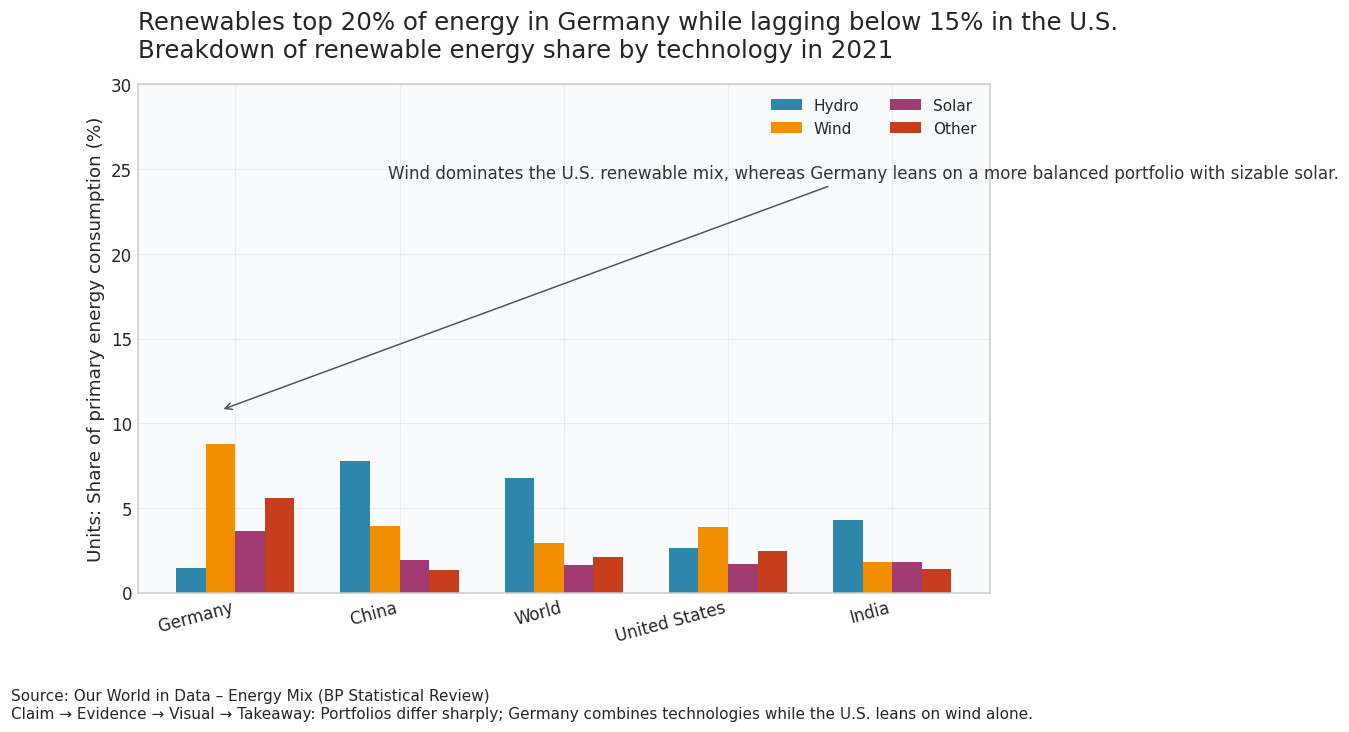

In [7]:
baseline_style()
categories = ["hydro_pct", "wind_pct", "solar_pct", "other_pct"]
labels = ["Hydro", "Wind", "Solar", "Other"]
colors = COLORBLIND_FRIENDLY[:len(categories)]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.18
indices = range(len(focus))

for i, (cat, label, color) in enumerate(zip(categories, labels, colors)):
    offsets = [idx + i * bar_width for idx in indices]
    ax.bar(offsets, focus[cat], width=bar_width, label=label, color=color)

ax.set_xticks([idx + bar_width * (len(categories) - 1) / 2 for idx in indices])
ax.set_xticklabels(focus["Entity"], rotation=15, ha="right")
ax.set_ylabel(UNITS)

title_text = TITLE + "\n" + SUBTITLE
ax.set_title(title_text, loc="left", pad=18)
ax.legend(frameon=False, ncol=2)

max_country = focus.iloc[0]
ax.annotate(
    ANNOTATION,
    xy=(0 + bar_width, max_country["wind_pct"] + 2),
    xytext=(1.2, focus["renewables_pct"].max() + 5),
    arrowprops=dict(arrowstyle="->", color="#555"),
    fontsize=11,
    color="#333",
)

ax.set_ylim(0, max(30, focus["renewables_pct"].max() + 10))

caption_text = SOURCE + "\n" + "Claim → Evidence → Visual → Takeaway: Portfolios differ sharply; Germany combines technologies while the U.S. leans on wind alone."
fig.text(0.01, -0.08, caption_text, fontsize=10)
plt.show()


### Accessibility checklist
- Color palette tested for deuteranopia safety.
- Bars labeled via legend with text, not just color.
- Annotation arrow and text highlight the narrative contrast.
- Percent axis starts at zero to avoid exaggeration.

In [8]:
save_last_fig("day02_solution_plot.png")


Figure saved to plots/day02_solution_plot.png


<Figure size 704x528 with 0 Axes>

## Step 6. Reflect on teaching and uncertainty
- Shares depend on BP's accounting of primary energy; biofuels and waste may be grouped into "other".
- Country-level policy changes (feed-in tariffs, tax credits) explain rapid shifts but aren't captured in the data.
- Encourage students to explore a second year (e.g., 2000) to discuss change over time.
- Ask learners to note any surprising technology mixes and hypothesize the underlying drivers.